# Exploring Equivariant Neural Networks

## Building a robust and efficient model for `Binary Classification` in PyTorch

### Dataset Description: A set of simulated 10,000 strong gravitational lensing images with and without substructure. 

In [1]:
# Importing necessary libraries
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting styles
%matplotlib inline
sns.set_style('darkgrid')

# Setting random seed
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# Setting the number of images to be processed in each 
batch_size = 32

# Setting size of test and validation datasets
test_size = 0.1 # 10%
valid_size = 0.1 # 10%
classes = [0,1]

## Data

### Data Loading

`ToTensor` converts a PIL Image or `numpy.ndarray` (H x W x C) in the range [0, 255] to a `torch.FloatTensor` of shape (C x H x W) in the range [0.0, 1.0]

In [4]:
import torchvision.transforms as transforms

# Defining a transform to resize the images to (224,224) and converting them to Tensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
from torchvision import datasets

# Specifying the path of data
data_path = r'./lenses'

# Creating a dataset to store the data
data = datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
print("Total number of images: ", len(data))

Total number of images:  10000


### Data Exploration

The `class_to_idx` function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [6]:
data.class_to_idx

{'no_sub': 0, 'sub': 1}

In [7]:
# Creating a function to reverse map the class ID's to class
lab2class = {v: k for k, v in data.class_to_idx.items()}
lab2class

{0: 'no_sub', 1: 'sub'}

In [8]:
# Creating a function which returns the class distribution of the dataset
def get_class_distribution(data_object):
    count_dict = {k:0 for k,v in data_object.class_to_idx.items()}
    for _, label_id in data_object:
        label = lab2class[label_id]
        count_dict[label] += 1
    return count_dict

In [9]:
# A function to display the bar graph plot of a dictionary object
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

Text(0.5, 1.0, 'Dataset Distribution (before Train/Test/Val split)')

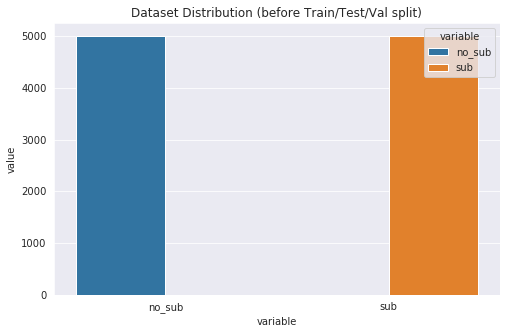

In [10]:
# Viewing the class distribution of the data before splitting
plt.figure(figsize=(8,5))
plot_from_dict(get_class_distribution(data), plot_title="Dataset Distribution (before Train/Test/Val split)")

The entire data will be divided into three parts
1. <b>Training Dataset (80%)</b> : Used for training the Classification model
2. <b>Validation Dataset (10%)</b> : For estimating the model skills, and using it to tune the hyperparameters
3. <b>Test Dataset (10%)</b>: For testing our model

I have used `SubsetRandomSampler` for making dataset loaders so that each batch receives a random distribution of classes

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

# Testing
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

# Validation
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Samplers for obtaining the batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler = test_sampler,  num_workers=1)

In [13]:
print("Batches in Training Dataset: ",len(train_loader))
print("Batches in Test Dataset: ",len(test_loader))
print("Batches in Validation Dataset: ",len(valid_loader))

Batches in Training Dataset:  254
Batches in Test Dataset:  32
Batches in Validation Dataset:  29


In [14]:
# Viewing the class distribution of the data loaders
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = lab2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = lab2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Validation Dataset')

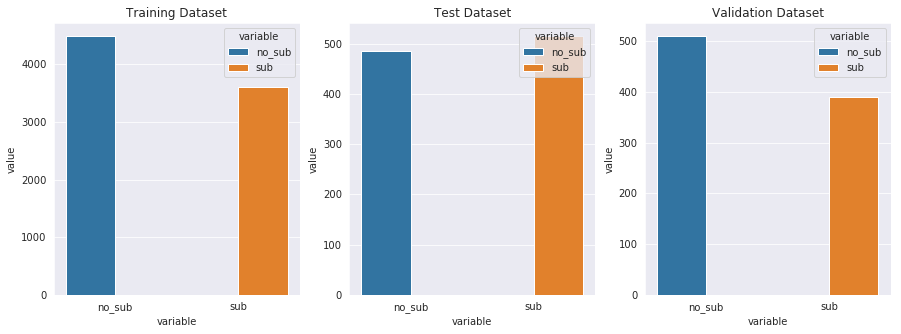

In [15]:
# Plotting the class distribution of the three data loaders
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_from_dict(get_class_distribution_loaders(train_loader, data), plot_title="Training Dataset", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(test_loader, data), plot_title="Test Dataset", ax=axes[1])
plot_from_dict(get_class_distribution_loaders(valid_loader, data), plot_title="Validation Dataset", ax=axes[2])

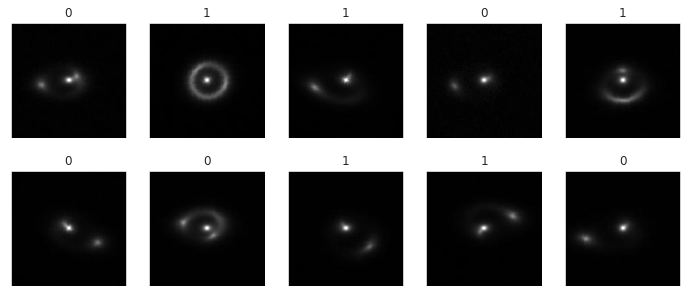

In [16]:
# A function to un-normalize and display an image
def imshow(img):
#     img = img / 2 + 0.5  # for un-normalizing the image
    plt.imshow(np.transpose(img, (1, 2, 0)))  # to convert from Tensor
    
# Obtaining a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converting the images to numpy for display

# Plotting the images in the batch, along with their corresponding class IDs
fig = plt.figure(figsize=(12, 5))

for id in np.arange(10):    # Displaying 10 images from the batch
    ax = fig.add_subplot(2, 10/2, id+1, xticks=[], yticks=[])
    imshow(images[id])
    ax.set_title(classes[labels[id]])

## Building the Model

### Defining the Model

In [17]:
import torch.nn as nn
import torch.nn.functional as F
CUDA_available = torch.cuda.is_available()  # Check if CUDA is available

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # maxpooling layer
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

model = Net()
print(model)

# Move to GPU if CUDA is available
if CUDA_available:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax()
)


### Model Summary

In [18]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
         MaxPool2d-2         [-1, 16, 110, 110]               0
            Conv2d-3         [-1, 32, 106, 106]          12,832
         MaxPool2d-4           [-1, 32, 53, 53]               0
           Dropout-5           [-1, 32, 53, 53]               0
            Linear-6                  [-1, 256]      23,011,584
            Linear-7                   [-1, 84]          21,588
           Dropout-8                   [-1, 84]               0
            Linear-9                    [-1, 2]             170
       LogSoftmax-10                    [-1, 2]               0
Total params: 23,047,390
Trainable params: 23,047,390
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.50
Params size (MB): 87.92
Est

## Training the Model

### Setting the hyperparameters

In [19]:
import torch.optim as optim

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Learning Rate
learning_rate = 0.003

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, nesterov=True)

### Training and Validation

In [20]:
# Number of epochs
n_epochs = 50

valid_loss_min = np.Inf # For tracking the change in validation loss
train_losses = [] # To store training losses
valid_losses = [] # To store validation losses

for epoch in range(1, n_epochs+1):
    
    # For tracking of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training the model
    model.train()
    for data, target in train_loader:
        # Move to GPU if CUDA is available
        if CUDA_available:
            data, target = data.cuda(), target.cuda()            
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()        
        # Forward Pass: Compute predicted outputs by passing inputs to the model
        output = model(data)        
        # Calculating the batch loss
        loss = criterion(output, target)
        # Backward Pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        # Performing a single optimization step (Updating the parameters)
        optimizer.step()
        # Updating the training loss
        train_loss += loss.item()*data.size(0)
        
    #Validating the model
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # Move to GPU if CUDA is available
            if CUDA_available:
                data, target = data.cuda(), target.cuda()
            # Forward Pass: Compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # Calculating the batch loss
            loss = criterion(output, target)
            # Updating the average validation loss 
            valid_loss += loss.item()*data.size(0)
    
    # Calculating the average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Displaying the training and validation statistics
    print('')
    print('Epoch [{}/{}]: \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, n_epochs, train_loss, valid_loss))
    
    # Saving the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased from ({:.6f} to {:.6f}).  \tSaving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_classification.pt')
        valid_loss_min = valid_loss


Epoch [1/50]: 	Training Loss: 0.556672 	Validation Loss: 0.061489
Validation loss decreased from (inf to 0.061489).  	Saving model ...

Epoch [2/50]: 	Training Loss: 0.552673 	Validation Loss: 0.060260
Validation loss decreased from (0.061489 to 0.060260).  	Saving model ...

Epoch [3/50]: 	Training Loss: 0.481851 	Validation Loss: 0.054740
Validation loss decreased from (0.060260 to 0.054740).  	Saving model ...

Epoch [4/50]: 	Training Loss: 0.369987 	Validation Loss: 0.036625
Validation loss decreased from (0.054740 to 0.036625).  	Saving model ...

Epoch [5/50]: 	Training Loss: 0.319951 	Validation Loss: 0.030863
Validation loss decreased from (0.036625 to 0.030863).  	Saving model ...

Epoch [6/50]: 	Training Loss: 0.291718 	Validation Loss: 0.027426
Validation loss decreased from (0.030863 to 0.027426).  	Saving model ...

Epoch [7/50]: 	Training Loss: 0.274448 	Validation Loss: 0.027870

Epoch [8/50]: 	Training Loss: 0.262646 	Validation Loss: 0.028321

Epoch [9/50]: 	Training 

### Visualising Training and Validation Losses

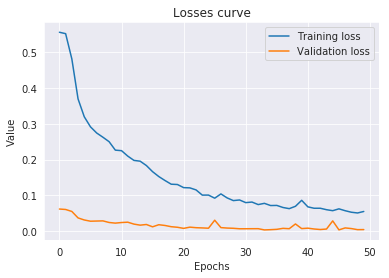

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Losses curve')
plt.legend()
plt.show()

As we can see, after 3 epochs, there is a sharp fall in <b>Training</b> and <b>Validation losses</b>

## Testing 

In [22]:
# Tracking the test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

# Storing the actual and predicated values by the model for further analysis
y_true_list = []
y_pred_list = []

# For confusion matrix for analysis
nb_classes = 2
cf_matrix = np.zeros((nb_classes, nb_classes))

model.eval()
i=1
len(test_loader)

# Iterating over test data
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # Move to GPU if CUDA is available
    if CUDA_available:
        data, target = data.cuda(), target.cuda()
    
    # Forward Pass: Compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # Calculating the batch loss
    loss = criterion(output, target)
    
    # Updating the test loss
    test_loss += loss.item()*data.size(0)
    
    # Converting the output probabilities to predicted class
    _, pred = torch.max(output, dim=1)    
    
    # Appending the values to the list for analysis later
    y_pred_list.append(pred.cpu().numpy())
    y_true_list.append(target.cpu().numpy())
    
    # Comparing the predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not CUDA_available else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculating the test accuracy for each object class
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
    # For confusion matrix  
    for tar, pre in zip(target.view(-1), pred.view(-1)):
        cf_matrix[tar.long(), pre.long()] += 1

# Flattening out the lists
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

# Calculating Test Loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.004137



## Analyzing Model results

### Accuracy

In [23]:
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else: # A check if no training examples present
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 96% (462/481)
Test Accuracy of     1: 99% (510/511)

Test Accuracy (Overall): 97% (972/992)


### Classification Report

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        17

   micro avg       1.00      1.00      1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



### Confusion Matrix

Text(0.5, 23.09375, 'Predicted label')

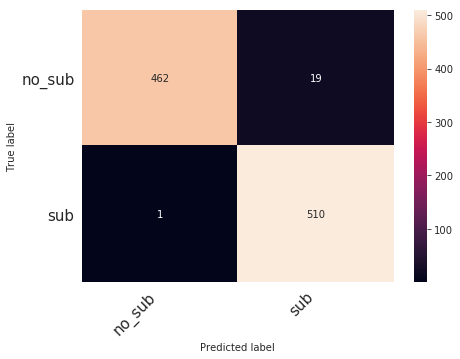

In [25]:
plt.figure(figsize=(7,5))

class_names = list(lab2class.values())
df_cm = pd.DataFrame(cf_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### ROC curve

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_true_list,y_pred_list)
roc_score = roc_auc_score(y_true_list,y_pred_list)

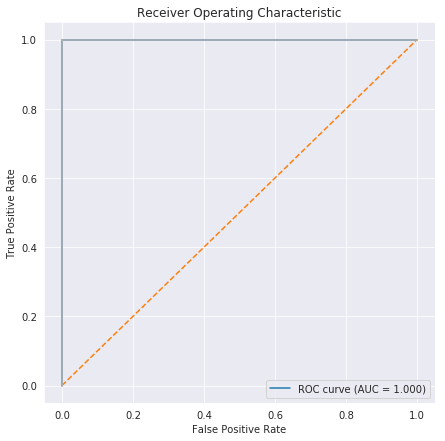

In [27]:
plt.subplots(1, figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(roc_score))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()